# Final Presentation part2

* BigLittleNet [repo](https://github.com/IBM/BigLittleNet)/ [paper](https://openreview.net/pdf?id=HJMHpjC9Ym)
* ResNeSt+SimplePose



<kbd>环境配置</kbd> <br />

In [1]:
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import makedirs, download
from gluoncv.model_zoo import get_model
from gluoncv.utils import LRScheduler
from gluon_plot import draw_efficient_curve


In [2]:
gluoncv.__version__

'0.8.0'

In [3]:
record = draw_efficient_curve("Calculate")

<kbd>1. ResnetV1 && ResnetV2  </kbd> <br />

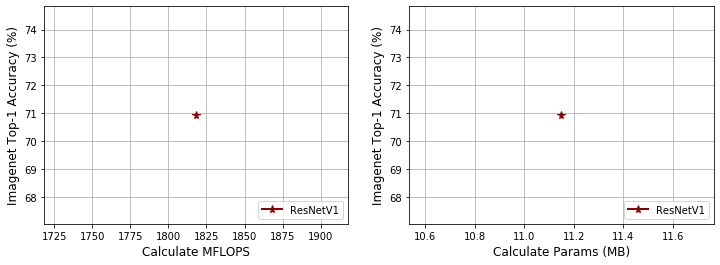

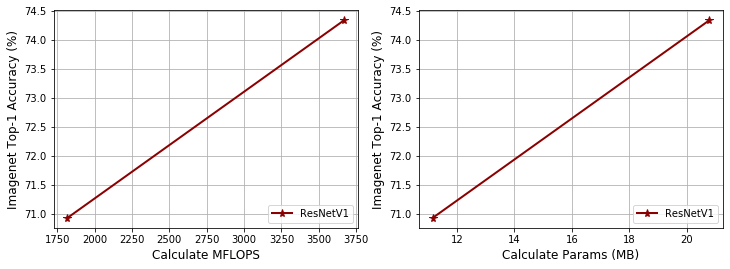

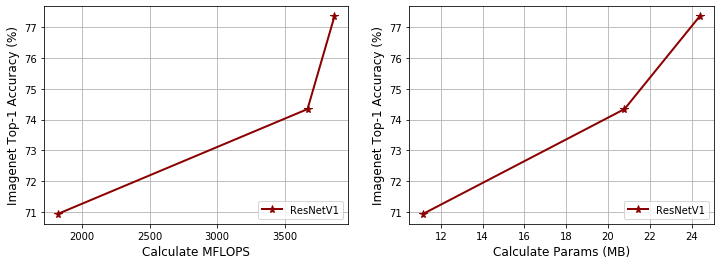

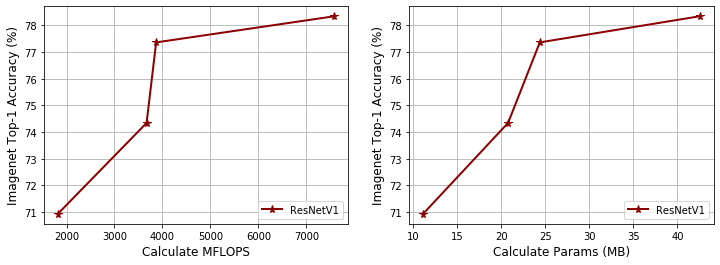

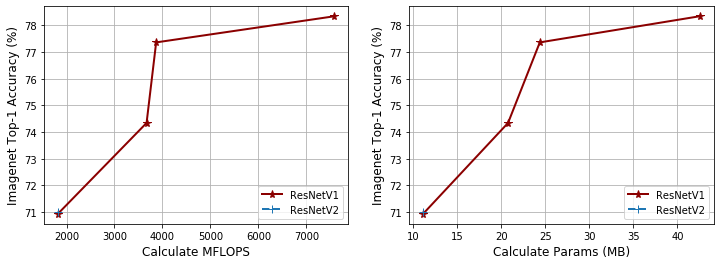

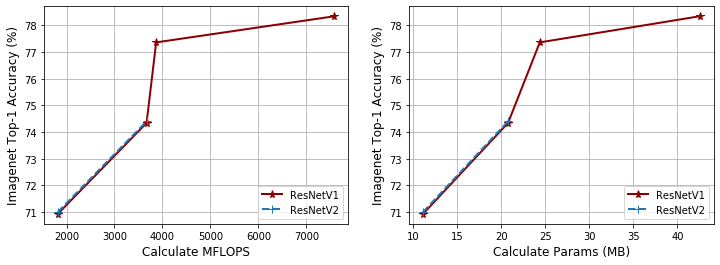

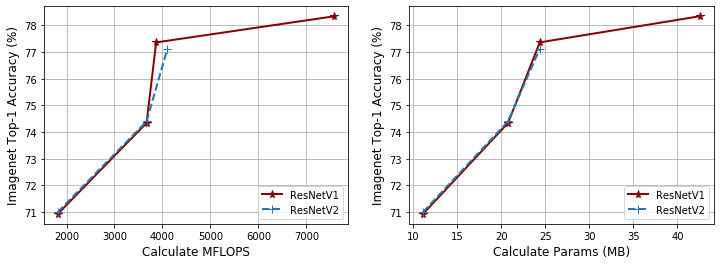

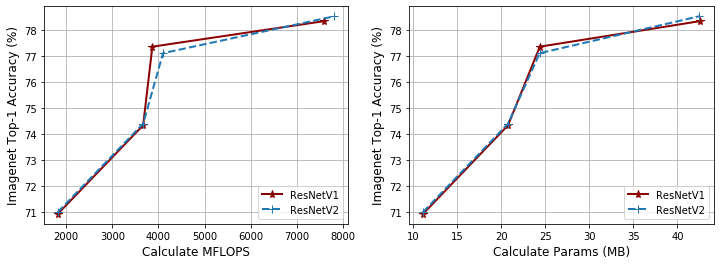

In [4]:
# resnetV1
record.plot('ResNetV1', 1818.21, 11.15, 70.93) # 71.6) # 18
record.plot('ResNetV1', 3669.16, 20.79, 74.34) # 76.0) # 34
record.plot('ResNetV1', 3868.96, 24.39, 77.36) # 78.6) # 50
record.plot('ResNetV1', 7586.30, 42.52, 78.34) # 79.9) # 101

# resnetV2
record.plot('ResNetV2', 1818.41, 11.15, 71.0) # 72.5)
record.plot('ResNetV2', 3669.36, 20.79, 74.4) # 75.8)
record.plot('ResNetV2', 4100.90, 24.37, 77.11) # 78.0)
record.plot('ResNetV2', 7818.24, 42.48, 78.53) # 79.2)

<kbd>2. BL-ResNet50 && BL-ResNet101  </kbd> <br />


<img src="sample/blaphabeta.png" width="80%">

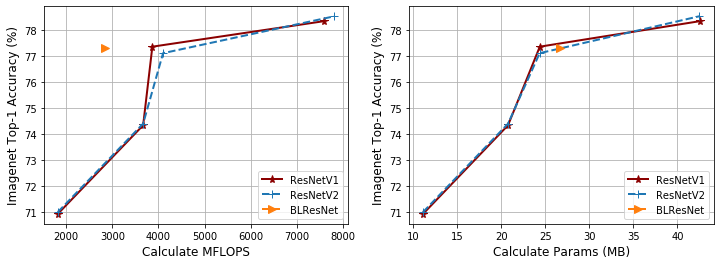

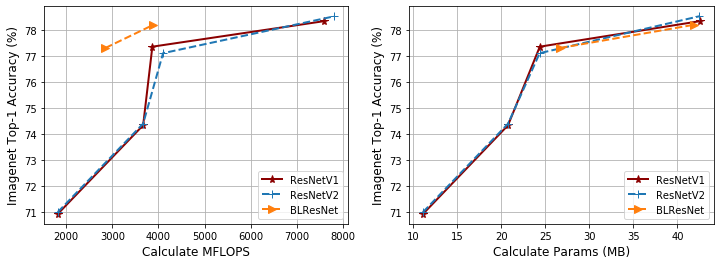

In [5]:
record.plot('BLResNet', 2850, 26.69, 77.31)
record.plot('BLResNet', 3890, 41.85, 78.20)

BLResNet50/101与原版ResNet50/ResNet101相比，在参数量略微增加，flops比原版ResNet要少，但accuracy并没有损失。

Big/Little Branch是怎么操作的，举例说明在不同的stage，和原来的bottlenet有什么不同。

<img src="sample/blresnetv3.png" width="90%">

<table><tr>
<td>
    Residual Block
<img src=sample/residual.png border=0></td>
<td>Downsampling Block
    <img src=sample/downsampling_original.png border=0></td>
</tr></table>



<table><tr>
    <td>Big Little Module <br>
        [big 64-> 256 ] s2*2 <br>
        [little 64 -> 128 ->256] *1 <br>
        [fusion 256 ->256 ] s2*1 
<img src="sample/blblock.JPG"></td>
    <td>Residual Block <br>
        [bottlenect 64->256 ]
<img src=sample/residual.png width="80%" border=0>
    Downsampling Block <br>
        [bottlenect 128->512 ] s2
    <img src=sample/downsampling_original.png width="80%" border=0>
    

实验结果，在性能相近情况下，节省20～25的flops

alpha/beta的含义即为 Little分支的channel缩减因子/ beta即为Block的缩减因子(3/4/6/3)-> (1,1,1,1)

<img src="sample/compare_table.png" width="90%">

Simple Pose with ResneSt Training

<img src="sample/simple_pose.png" width="70%">

ResNeSt50 逼近ResNet101v1b

ResNeSt101 逼近ResNet152v1b

<div class="alert alert-info">
<h4>Draft</h4>

In [ ]:
def get_model_info(name, pretrained=True, summary=False):
    if name == 'blresnet50_v1':
        pretrained=False
    if pretrained:
        net = get_model(name, pretrained=pretrained)
    else:
        from blresnet import get_blmodel
        net = get_blmodel(name) # 'blresnet50_v1'
        net.initialize()
    x = mx.nd.random.normal(shape=(1, 3, 224, 224))
    if summary:
        net.summary(x)
    net.hybridize()
    out = net(x)
    net.export(name)
    gluoncv.utils.viz.plot_network(net, (1, 3, 224, 224), 'sample/{}'.format(name))
    return net

In [ ]:
def stat_model(name, pretrained=True, summary=False):
    t = get_model_info(name, pretrained=pretrained, summary=summary)        
    print('load {} model.'.format(name))
    return t

In [10]:
model_name = input()
a = stat_model(model_name, summary=False) # True # a.summary
!python calculate_flops.py -s $model_name  -ds data,1,3,224,224
!python verify_imagenet.py --model $model_name 

Done.


<kbd>2. BigLittle Network</kbd> <br />

In [3]:
from blresnet import get_blmodel
# blnet = get_blmodel('blresnet50_v1')

In [4]:
def get_blnet():
    blnet = get_blmodel('blresnet50_v1')
    blnet.initialize()
    return blnet
t = get_blnet()

In [10]:
import mxnet as mx
blnet = get_blmodel('blresnet50_v1')
blnet.initialize()
blnet.hybridize()
x = mx.nd.random.normal(shape=(1, 3, 224, 224))
out = blnet(x)
blnet.export("blresnet50_v1")

In [9]:
t.summary

<bound method Block.summary of BLResNetV1(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): BLModule_0(
      (relu): Activation(relu)
      (big_branch): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      )
      (little_branch): HybridSequential(
        (0): Conv2D(64 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (2): Activation(relu)
        (3): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm(axis=

In [10]:
x = mx.nd.ones((1, 3, 224, 224))

In [11]:
t.summary(x)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            9408
         BatchNorm-2                           (1, 64, 112, 112)             256
        Activation-3                           (1, 64, 112, 112)               0
            Conv2D-4                             (1, 64, 56, 56)           36864
         BatchNorm-5                             (1, 64, 56, 56)             256
            Conv2D-6                           (1, 32, 112, 112)           18432
         BatchNorm-7                           (1, 32, 112, 112)             128
        Activation-8                           (1, 32, 112, 112)               0
            Conv2D-9                             (1, 32, 56, 56)            9216
        BatchNorm-10        

In [13]:
gluoncv.utils.viz.plot_network(t, (1, 3, 224, 224), 'sample/blresnet')

In [ ]:
download('https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/mt_baker.jpg', path='./')
filename = 'mt_baker.jpg'
img = mx.image.imread(filename)
plt.imshow(img.asnumpy())

In [5]:
transformed_img = gluoncv.data.transforms.presets.imagenet.transform_eval(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


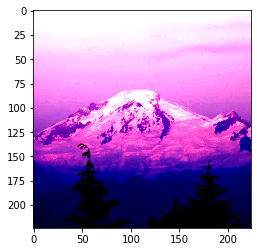

In [6]:
import numpy as np
plt.imshow(np.transpose(transformed_img[0].asnumpy(), (1, 2, 0)))

In [7]:
pred = net(transformed_img)

In [ ]:
# json wrong
from gluoncv.utils import export_block
export_block('resnet50_v1', net, preprocess=True, layout='HWC')
print('resnet50_v1-symbol.json Done.')

In [ ]:
net = get_model("yolo3_darknet53_voc", pretrained=True)
net.hybridize()
x = mx.nd.random.normal(shape=(1, 3, 416, 416))
out = net(x)
net.export("yolo3_darknet53_voc")

In [ ]:
!python calculate_flops.py -s yolo3_darknet53_voc-symbol.json -ds data,1,3,224,224 

In [43]:
!python calculate_flops.py -s resnet50_v1d-symbol.json -ds data,1,3,224,224 -ls resnetv1d_dense0_bias,1000

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:67: UserWarning: Data provided by label_shapes don't match names specified by label_names ([DataDesc[resnetv1d_dense0_bias,(1000,),<class 'numpy.float32'>,NCHW]] vs. [])
  warnings.warn(msg)
Traceback (most recent call last):
  File "calculate_flops.py", line 70, in <module>
    model.bind(data_shapes=data_shapes, label_shapes=label_shapes, for_training=False)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/module.py", line 429, in bind
    state_names=self._state_names)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/executor_group.py", line 280, in __init__
    self.bind_exec(data_shapes, label_shapes, shared_group)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/executor_group.py", line 362, in bind_exec
    self.label_layouts = self.decide_slices(label_shapes)
  File "/home/

In [8]:
!cd sample && stat resnet50_v1c

  File: resnet50_v1c
  Size: 48740     	Blocks: 96         IO Block: 4096   regular file
Device: ca01h/51713d	Inode: 65799227    Links: 1
Access: (0664/-rw-rw-r--)  Uid: ( 1000/  ubuntu)   Gid: ( 1000/  ubuntu)
Access: 2020-08-18 02:33:26.275358517 +0000
Modify: 2020-08-18 02:33:26.247358547 +0000
Change: 2020-08-18 02:33:26.247358547 +0000
 Birth: -


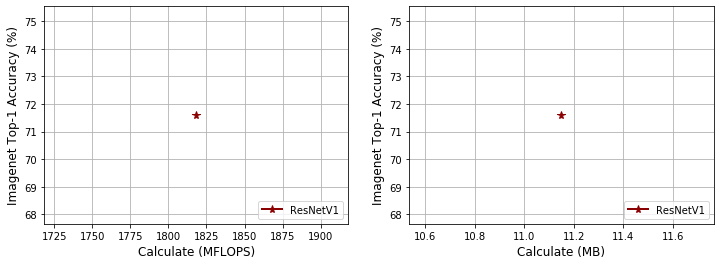

{'ResNetV1': ([1818.21], [71.6])}
{'ResNetV1': ([11.15], [71.6])}
Successfully draw the tradeoff curve!


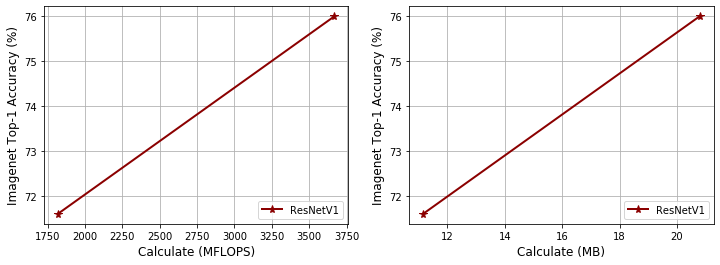

{'ResNetV1': ([1818.21, 3669.16], [71.6, 76.0])}
{'ResNetV1': ([11.15, 20.79], [71.6, 76.0])}
Successfully draw the tradeoff curve!


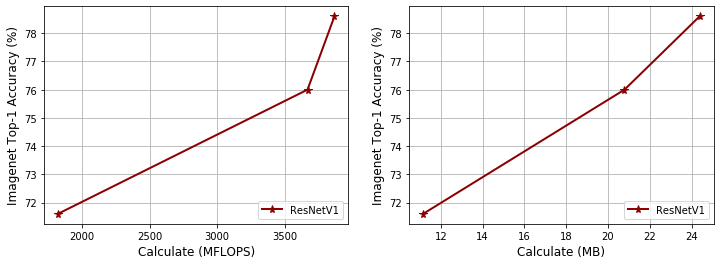

{'ResNetV1': ([1818.21, 3669.16, 3868.96], [71.6, 76.0, 78.6])}
{'ResNetV1': ([11.15, 20.79, 24.39], [71.6, 76.0, 78.6])}
Successfully draw the tradeoff curve!


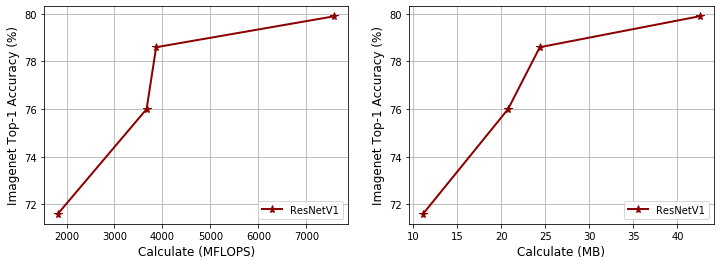

{'ResNetV1': ([1818.21, 3669.16, 3868.96, 7586.3], [71.6, 76.0, 78.6, 79.9])}
{'ResNetV1': ([11.15, 20.79, 24.39, 42.52], [71.6, 76.0, 78.6, 79.9])}
Successfully draw the tradeoff curve!


In [12]:
# resnetV1
record.plot('ResNetV1', 1818.21, 11.15, 71.6) # 18
record.plot('ResNetV1', 3669.16, 20.79, 76.0) # 34
record.plot('ResNetV1', 3868.96, 24.39, 78.6) # 50
record.plot('ResNetV1', 7586.30, 42.52, 79.9) # 101



# resnetV1b

# resnetV1c

# resnetV1d

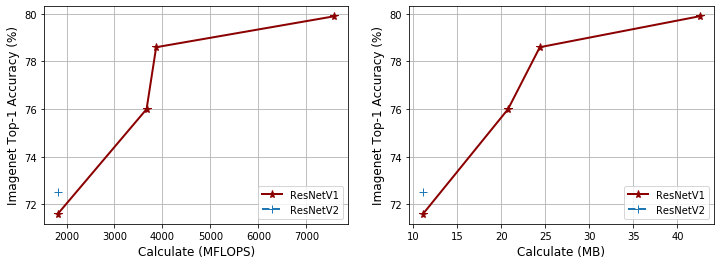

{'ResNetV1': ([1818.21, 3669.16, 3868.96, 7586.3], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([1818.41], [72.5])}
{'ResNetV1': ([11.15, 20.79, 24.39, 42.52], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([11.15], [72.5])}
Successfully draw the tradeoff curve!


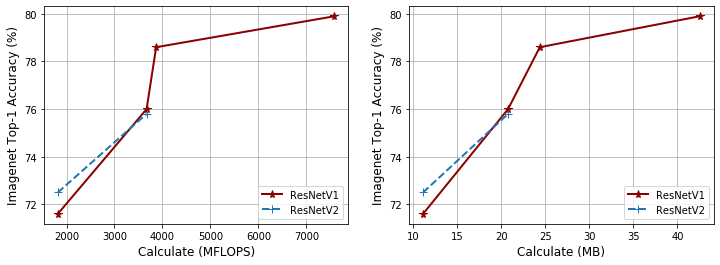

{'ResNetV1': ([1818.21, 3669.16, 3868.96, 7586.3], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([1818.41, 3669.36], [72.5, 75.8])}
{'ResNetV1': ([11.15, 20.79, 24.39, 42.52], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([11.15, 20.79], [72.5, 75.8])}
Successfully draw the tradeoff curve!


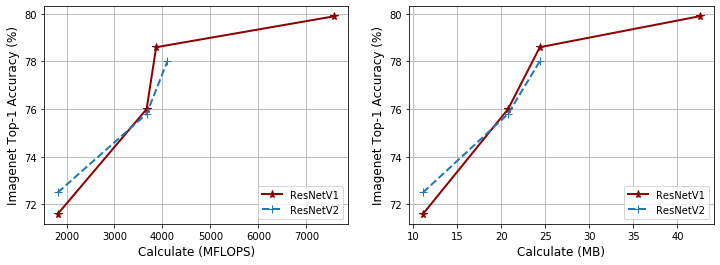

{'ResNetV1': ([1818.21, 3669.16, 3868.96, 7586.3], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([1818.41, 3669.36, 4100.9], [72.5, 75.8, 78.0])}
{'ResNetV1': ([11.15, 20.79, 24.39, 42.52], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([11.15, 20.79, 24.37], [72.5, 75.8, 78.0])}
Successfully draw the tradeoff curve!


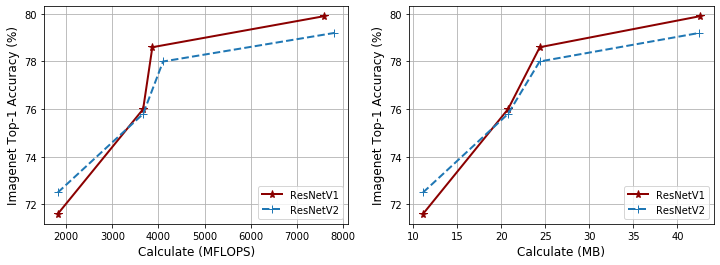

{'ResNetV1': ([1818.21, 3669.16, 3868.96, 7586.3], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([1818.41, 3669.36, 4100.9, 7818.24], [72.5, 75.8, 78.0, 79.2])}
{'ResNetV1': ([11.15, 20.79, 24.39, 42.52], [71.6, 76.0, 78.6, 79.9]), 'ResNetV2': ([11.15, 20.79, 24.37, 42.48], [72.5, 75.8, 78.0, 79.2])}
Successfully draw the tradeoff curve!


In [17]:
# resnetV2
record.plot('ResNetV2', 1818.41, 11.15, 72.5)
record.plot('ResNetV2', 3669.36, 20.79, 75.8)
record.plot('ResNetV2', 4100.90, 24.37, 78.0)
record.plot('ResNetV2', 7818.24, 42.48, 79.2)